In [154]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

In [155]:
COST = yf.download(tickers=["MGLU3.SA"], start="2015-01-01")["Adj Close"]
WMT = yf.download(tickers=["WEGE3.SA"], start="2015-01-01")["Adj Close"]
TGT = yf.download(tickers=["GGBR4.SAL"], start="2015-01-01")["Adj Close"]
DG = yf.download(tickers=["DG"], start="2015-01-01")["Adj Close"]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- GGBR4.SAL: No timezone found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed


<Axes: xlabel='Date'>

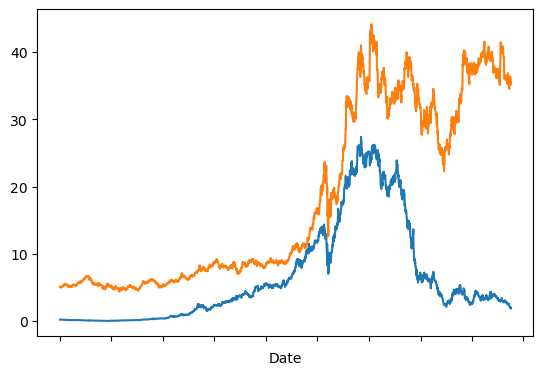

In [156]:
COST.plot()
WMT.plot()
TGT.plot()

In [157]:
retail= yf.download(tickers=["MGLU3.SA", "COST", "WEGE3.SA", "DG"], start="2015-01-01")["Adj Close"]
retail

[*********************100%***********************]  4 of 4 completed


,COST,DG,MGLU3.SA,WEGE3.SA
Date,,,,
2015-01-02,118.242523,64.749695,0.215259,5.088045
2015-01-05,116.898216,64.328880,0.219304,5.122736
2015-01-06,118.442955,63.514706,0.216414,5.046746
2015-01-07,120.505394,64.283127,0.223638,4.988927
2015-01-08,121.540726,63.587879,0.221905,5.073177
...,...,...,...,...
2023-09-28,568.630005,105.370003,2.050000,36.389999
2023-09-29,564.960022,105.800003,2.120000,36.270000
2023-10-02,571.309998,103.779999,2.010000,36.150002


<Axes: xlabel='Date'>

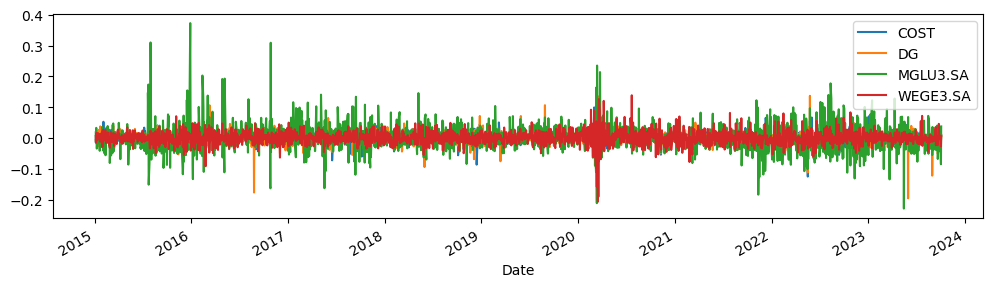

In [158]:
#daily returns
retail_retuns = retail.pct_change(1).dropna()
retail_retuns.plot(figsize=(12,3))

<Axes: ylabel='Frequency'>

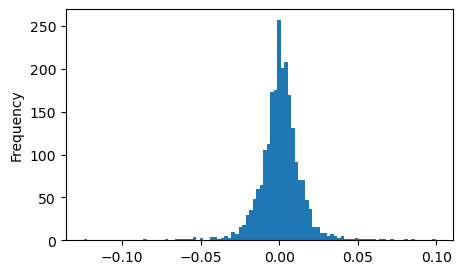

In [159]:
retail_retuns["COST"].plot(kind="hist", bins=100,figsize=(5,3))

<Axes: xlabel='Date'>

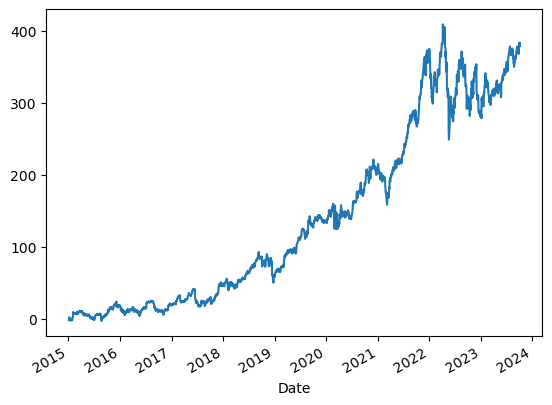

In [160]:
# cumulative retunr in 1 dolar
dolar =1
#(dolar + retail_retuns["COST"]).cumprod()

# cumulative retunr in 1 dolar percentage
cumulative_return = (dolar + retail_retuns["COST"]).cumprod() -1
cumulative_return_pct = 100* cumulative_return


# ver quantos % rendeu em um preiodo de tempo
cumulative_return_pct.plot()

In [161]:
# np.dot colocar pesos(%) de alocações em cada ativo
weights = [0.25,0.25,0.25,0.25]
equal_retunrs = np.dot(weights, retail_retuns.transpose())

cumulative_equal_weighted_returns = (1+equal_retunrs).cumprod() -1
cumulative_equal_weighted_returns = 100*cumulative_equal_weighted_returns

In [162]:
cumulative_equal_weighted_returns

array([ 1.93551627e-01, -4.94062435e-01,  7.85450883e-01, ...,
        6.56938909e+02,  6.37027528e+02,  6.48235661e+02])

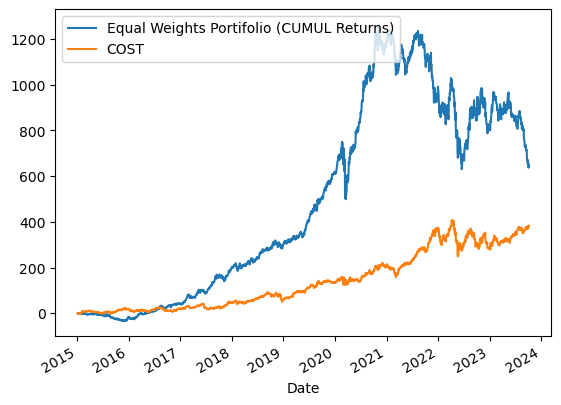

In [163]:
cewrp = pd.Series(cumulative_equal_weighted_returns, index=retail_retuns.index)
cewrp.plot(label="Equal Weights Portifolio (CUMUL Returns)")
cumulative_return_pct.plot()
plt.legend()

In [164]:
def gen_weights(N):
    weights = np.random.random(N)
    return weights/np.sum(weights)

In [165]:
weights =gen_weights(len(retail.columns))
weights

array([0.10433782, 0.29583419, 0.26075694, 0.33907105])

In [166]:
def calculate_returns(weights, log_rets):
    return np.sum(log_rets.mean() * weights) * 252

In [167]:
def calculate_volatility(weights, log_rets_cov):
    annualized_cov = np.dot(log_rets_cov*252,weights)
    vol = np.dot(weights.transpose(),annualized_cov)
    return np.sqrt(vol)

In [168]:
log_rets = np.log(retail / retail.shift(1))
log_rets_cov = log_rets.cov()

In [169]:
mc_portifolio_returns = []
mc_portifolio_vol = []
mc_weights = []

for sim in range(3000):
    weights = gen_weights(N=4)
    mc_weights.append(weights)
    sim_returns = calculate_returns(weights,log_rets)
    mc_portifolio_returns.append(sim_returns)
    sim_vol = calculate_volatility(weights, log_rets_cov)
    mc_portifolio_vol.append(sim_vol)

In [170]:
risk_free = 0
print(risk_free)
mc_sharpe_ratios = np.array(mc_portifolio_returns)-risk_free/np.array(mc_portifolio_vol)

0


In [171]:
mc_sharpe_ratios

array([0.15526283, 0.19750336, 0.208122  , ..., 0.19707336, 0.15230385,
       0.16512408])

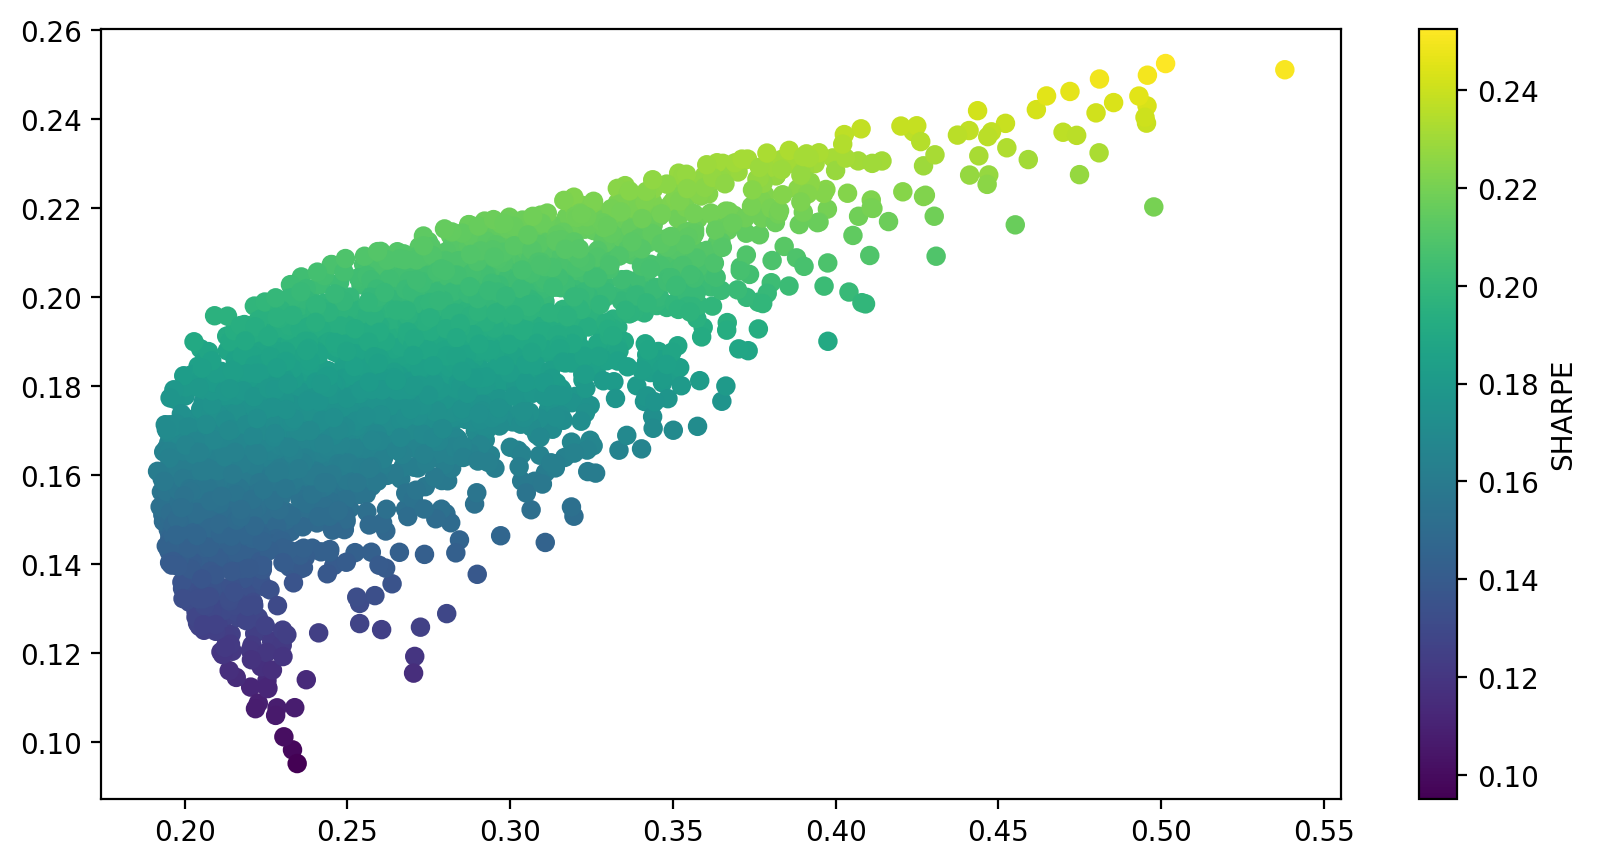

In [172]:
plt.figure(dpi=200,figsize=(10,5))
plt.scatter(mc_portifolio_vol,mc_portifolio_returns,c=mc_sharpe_ratios)
plt.xlabel=("Risco")
plt.colorbar(label="SHARPE" )


In [173]:
np.argmax(mc_sharpe_ratios)
mc_weights[1592]*100

array([22.53240562, 24.13565321, 25.03824276, 28.29369841])

In [174]:
mc_weights[1592]

array([0.22532406, 0.24135653, 0.25038243, 0.28293698])

In [192]:
#####minimization
from scipy.optimize import minimize

In [189]:
def function_to_minimize(weights):
    risk_free = 0
    #MINIMIZa -1 * SR
    return -1 * (calculate_returns(weights,log_rets)-risk_free/calculate_volatility(weights,log_rets_cov))

In [190]:
bounds = tuple((0,1) for n in range(N))
bounds

((0, 1), (0, 1), (0, 1), (0, 1))

In [191]:
sum_constraint = ({'type': 'eq', 'fun': lambda weights: np.sum(weights)-1})
minimize(fun=function_to_minimize,x0=equal_weights,bounds=bounds,constraints=sum_constraint)
np.sum(np.array([0.000e+00  0.000e+00  1.000e+00  0.000e+00

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.27582482199958136
       x: [ 0.000e+00  0.000e+00  1.000e+00  0.000e+00]
     nit: 6
     jac: [-1.831e-01 -6.443e-02 -2.758e-01 -2.003e-01]
    nfev: 30
    njev: 6

In [181]:
N = len(retail.columns)
equal_weights = N * [1/N] # Shows 1/4, 4 times. Its not multiplication, but repetition! 4*["A"]
equal_weights

[0.25, 0.25, 0.25, 0.25]

In [194]:
minimize(fun=function_to_minimaze,
        x0=equal_weights,
        bounds=bounds,
        constraints = sum_constraint)

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.27582482199958136
       x: [ 0.000e+00  0.000e+00  1.000e+00  0.000e+00]
     nit: 6
     jac: [-1.831e-01 -6.443e-02 -2.758e-01 -2.003e-01]
    nfev: 30
    njev: 6

<Axes: xlabel='Date'>

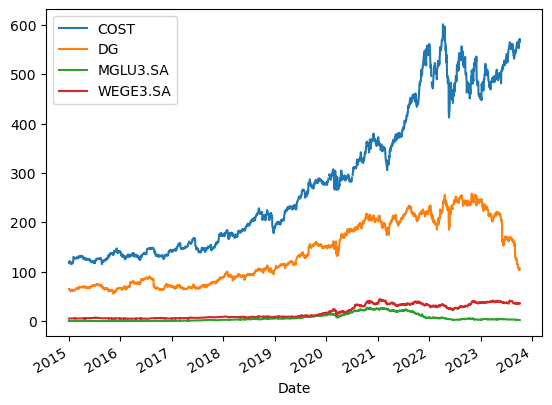

In [195]:
retail.plot()